In [63]:
import torch
import torchvision
import torch.nn as nn
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
import models.resnet_ECA_parallel_SC as resnet_ECA_parallel
import models.resnet_ECA_last_block_SC as resnet_ECA_last
from torchsummary import summary

plt.ion() # interactive mode
%matplotlib inline

In [64]:
net = resnet_ECA_last.resnet18()
# net.to('cuda:0')
# summary(net, (3,32,32))

model_names = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]
types = ["teacher", "student"]
index = 41
modelname = model_names[0]
type = types[1]
net.load_state_dict(
    torch.load(
        f"./saved_pth_model/{modelname}_{type}_{index}.pth",
        map_location=torch.device("cpu"),
    )
)

<All keys matched successfully>

In [65]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform_test = transforms.Compose(
    [
        # transforms.Grayscale(),
        transforms.ToTensor()
    ]
)

testset = torchvision.datasets.CIFAR10(root="./cifar10", train=False)

testLoader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

In [66]:
weights = []
conv_layers = []
count = 0
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        weights.append(m.weight)
        conv_layers.append(m)
        count += 1
    elif isinstance(m, nn.BatchNorm2d):
        weights.append(m.weight)
    elif isinstance(m, nn.Linear):
        weights.append(m.weight)
print(count)

20


In [67]:
transform = transforms.Compose([transforms.ToTensor()])

0
1
2
3
4
5
7
8
9
10
12
13
14
15
16
18
19
17
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 8, 8])


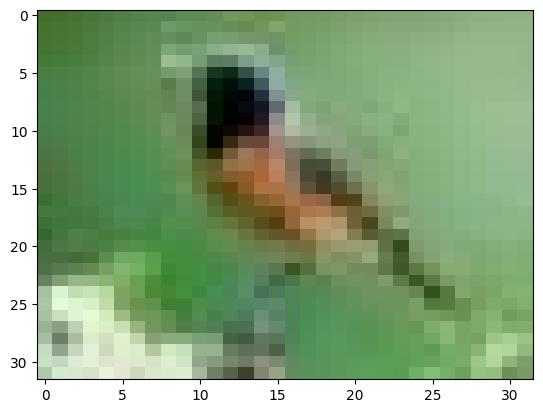

In [68]:
from PIL import Image


imgname = "bird"
image = Image.open(str(f"{imgname}.jpg"))
plt.imshow(image, aspect="auto")

image = transform(image)
image = image.unsqueeze(0)

outputs = []
names = []

# ***** Hacky solution to mismatsh in layers while testing multiple models
for i in range(count):
    # parallel
    # resnet34_teacher_6
    # if i == 8 or i == 17 or i == 30:
    #     continue

    # resnet18_student_6
    # if i == 6 or i == 11 or i == 16:
    #     continue

    # last
    # resnet18_student_41
    if i == 6 or i == 11 or i == 17:
        continue
    # resnet34 student 10
    # if i in [8,17,31]:
    #     continue
    # resnet152 teacher 10
    # if i in [2,3,4,12,13,14,37,38,39,146,147,148]:
    #     continue
    print(i)
    image = conv_layers[i](image)
    outputs.append(image)
    names.append(str(conv_layers[i]))
print(len(outputs))
for feature_map in outputs:
    print(feature_map.shape)

In [69]:
processed = []

for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append((gray_scale.data.cpu().numpy()))

for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(16, 16)
(16, 16)
(16, 16)
(16, 16)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)


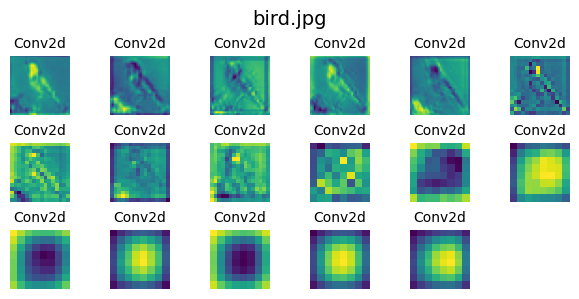

In [70]:
fig = plt.figure(figsize=(6, 10), layout="constrained")
fig.suptitle(f"{imgname}.jpg", fontsize=14)
for i in range(len(processed)):
    a = fig.add_subplot(15, 6, i + 1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split("(")[0], fontsize=10)

plt.savefig(
    str(f"./feature_maps/feature_maps_{modelname}_{type}_{index}_{imgname}.jpg"),
    bbox_inches="tight",
)
plt.show()

torch.Size([64, 3, 3, 3])


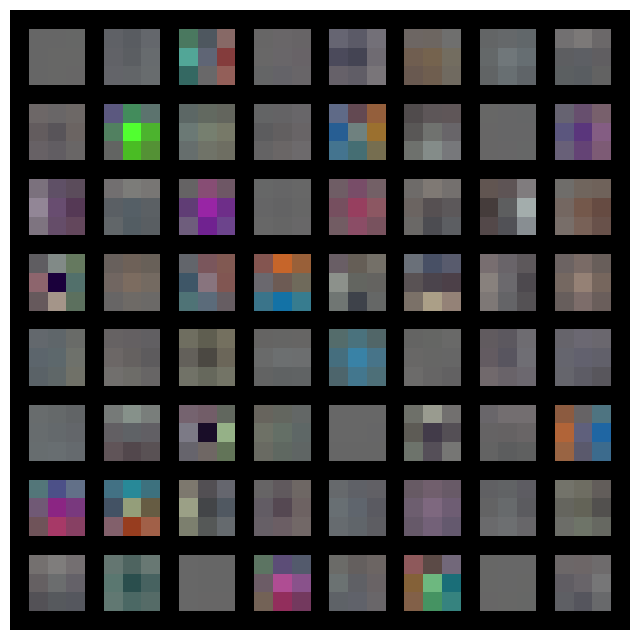

In [71]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt


def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n, c, w, h = tensor.shape
    if allkernels:
        tensor = tensor.view(n * c, -1, w, h)
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow, rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    n, c, w, h = tensor.shape
    if allkernels:
        tensor = tensor.view(n * c, -1, w, h)
    elif c != 3:
        tensor = tensor[:, ch, :, :].unsqueeze(dim=1)
    utils.save_image(tensor, filename, nrow=nrow)


vizable = []
for i in range(len(weights)):
    if weights[i].ndim == 4:
        vizable.append(i)


kernel = weights[vizable[0]].data.clone()
print(kernel.shape)

vistensor(kernel, ch=3, allkernels=False)
savetensor(kernel, "kernel.png", allkernels=False)

plt.axis("off")
plt.ioff()
plt.show()